# 5.1 Criação de Modelos de Machine Learning - Tunning

## Random Forest

## Carregar dados tratados

In [21]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:

from sklearn.ensemble import RandomForestClassifier


In [23]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

In [24]:
def split_dados(df, test_size: float = 0.2):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=test_size, random_state=42)

    return (X_treino, X_teste, y_treino, y_teste)

In [25]:
def plot_confusion_matrix_heat(cf_matrix):
    cf_matrix.index.name = 'Atual'
    cf_matrix.columns.name = 'Predito'
    
    cf_nd_array = cf_matrix.to_numpy()
    cf_flatten = cf_nd_array.flatten()

    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_flatten]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_flatten / np.sum(cf_nd_array)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    print(cf_matrix.shape)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')


In [97]:
def avaliar(y_teste, y_prev, nome_modelo):
    print(nome_modelo)
    print("Reporte teste")
    report = classification_report(y_teste, y_prev, target_names=["Vender", "Comprar"])
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_prev), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    plot_confusion_matrix_heat(cf_matrix)
    plt.show()
    metric = metrics.precision_score(y_teste, y_prev)
    print("Precision: ", metric)
    print("#" * 50)
    return metric

# ML modelo

In [27]:
def definir_modelo_ml() -> dict:
    return {
            "RandomForestClassifier": {'modelo_base': RandomForestClassifier(random_state=42), 'modelo_tunado': None},
            # "RandomForestClassifier_tunn": {'modelo_base': RandomForestClassifier(random_state=42), 'modelo_tunado': None}

           }

In [ ]:
def definir_modelo_ml() -> dict:
    model_dict = dict(
            RandomForestClassifier={'modelo_base': RandomForestClassifier(random_state=42),
                                    'modelo_tunado': None}
    )
    return model_dict

In [39]:
def treinar_modelo_base(modelos, splited_dados):

    X_treino, _, y_treino, y_test = splited_dados

    for nome, modelo in modelos.items():
        modelo = modelo.get('modelo_base')
        modelo.fit(X_treino, y_treino)
        modelos[nome]['modelo_base'] = modelo
    
    return modelos

## Tunning do modelo

In [29]:
def scale_data(df):
    scaler = StandardScaler()
    tabela_auxiliar = df.drop("decisao", axis=1)
    
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["decisao"] = df["decisao"]
    
    return tabela_auxiliar

In [96]:
def fit_tunning_rand_search_rand_forest(X_treino, y_treino):
    print("Tunning randomized search Random Forest")

    # Create the random params

    param = {
             "criterion": ["entropy"],
             "n_estimators": [100],
             "max_depth": [None],
             "min_samples_split": [2, 3],
             "min_samples_leaf": [1, 2, 3],
             "min_weight_fraction_leaf": [0],
             'max_features': ["auto"],
             'warm_start': [True],
             'random_state': [None],
             'n_jobs': [-1],
            }

    print(param)

    rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                   param_distributions=param,
                                   cv=10,
                                   verbose=0,
                                   scoring="precision",
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

In [99]:

def run_rand_forest_tunning(df, splited_dados):

    X_treino, X_teste, y_treino, y_teste = splited_dados
    
    resultado_grid = fit_tunning_rand_search_rand_forest(X_treino, y_treino)

    print("Ajuste Rand Forest feito")

    print("Best params", resultado_grid.best_params_)
    print("Best score", resultado_grid.best_score_)

    modelo_tunado = resultado_grid.best_estimator_
    print("----- * -----" * 5)

    return modelo_tunado

In [32]:
def compare_tunning(df, modelos: dict, splited_dados):

    _, X_teste, _, y_teste = splited_dados

    precisions = {}
    for nome, modelos_dict in modelos.items():
        prev = modelos_dict['modelo_base'].predict(X_teste)
        precisions[nome + '_base'] =  avaliar(y_teste, prev, nome + '_base')
        prev = modelos_dict['modelo_tunado'].predict(X_teste)
        precisions[nome + '_tunned'] = avaliar(y_teste, prev, nome + '_tunado')
    
    # barplot comparacao 3 modelos tunados
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=list(precisions.keys()), y=list(precisions.values()))
    ax.set(xlabel="Modelos", ylabel="Average precision", title="Precisao por Modelo")
    

In [33]:
def run_tunning_fit(df, modelos, splited_dados):
    '''
        Executa os tunnings com randomized search cv e armazena o modelo tunado
    '''
    modelos['RandomForestClassifier']['modelo_tunado'] = run_rand_forest_tunning(df, splited_dados)

    return modelos


Tunning randomized search Random Forest
{'criterion': ['entropy'], 'n_estimators': [100], 'max_depth': [None], 'min_samples_split': [2, 3], 'min_samples_leaf': [1, 2, 3], 'min_weight_fraction_leaf': [0], 'max_features': ['auto'], 'warm_start': [True], 'random_state': [None], 'n_jobs': [-1]}


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Ajuste Rand Forest feito
Best params {'warm_start': True, 'random_state': None, 'n_jobs': -1, 'n_estimators': 100, 'min_weight_fraction_leaf': 0, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy'}
Best score 0.5413339100374044
----- * ---------- * ---------- * ---------- * ---------- * -----
RandomForestClassifier_base
Reporte teste
              precision    recall  f1-score   support

      Vender       0.55      0.63      0.59       135
     Comprar       0.60      0.52      0.55       143

    accuracy                           0.57       278
   macro avg       0.57      0.57      0.57       278
weighted avg       0.58      0.57      0.57       278

(2, 2)


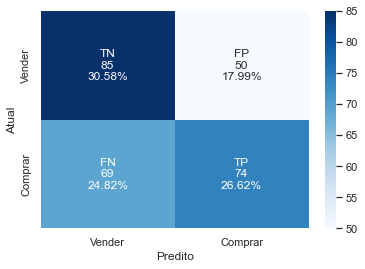

Precision:  0.5967741935483871
##################################################
RandomForestClassifier_tunado
Reporte teste
              precision    recall  f1-score   support

      Vender       0.56      0.59      0.58       135
     Comprar       0.59      0.56      0.58       143

    accuracy                           0.58       278
   macro avg       0.58      0.58      0.58       278
weighted avg       0.58      0.58      0.58       278

(2, 2)


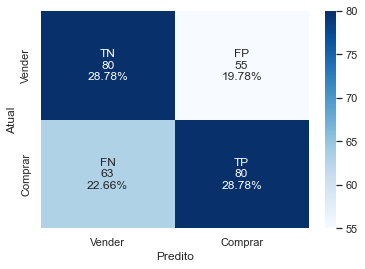

Precision:  0.5925925925925926
##################################################


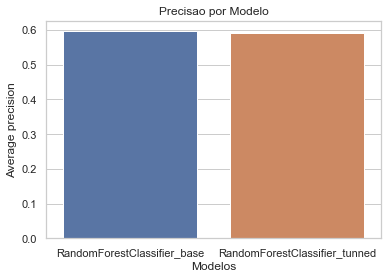

In [100]:
def main():

    df = carregar_joblib()

    modelo = definir_modelo_ml()

    splited_dados = split_dados(df, test_size=0.15)

    modelo = treinar_modelo_base(modelo, splited_dados)

    # df = scale_data(df)
    
    modelo = run_tunning_fit(df, modelo, splited_dados)

    compare_tunning(df, modelo, splited_dados)

    return df, modelo, splited_dados

df, modelos, splited_dados = main()